# Лабораторная работа "Открытый оптический резонатор"

## В  настоящем блокноте представлена  программа для графического представления  полученных осциллограмм в  случаях:
###              в режиме наилучшего согласования ООР и сканирующего интерферометра
###              в режиме умеренного согласования ООР и сканирующего интерферометра
###              в двухчастотном режиме работы лазеры


In [63]:
import numpy as np 
import matplotlib.pyplot as plt 
from scipy.signal import argrelextrema
from scipy.signal import find_peaks, peak_widths
from scipy.signal import savgol_filter
import copy
import math
from scipy.stats import t 

In [64]:
# Пути для данных и сохранения результатов
data_path =  "OOR_lab_data"
save_path = "results"


## Известные параметры

In [65]:
lamda = 632.8e-9  # длина волны лазера  
L_laser = 0.37    # длина резонатора лазера
c = 3e+8          # скорость света в вакууме 
R_interf = 1      # радиус кривизны сканирующего интерферометра 
L_interf = 0.05  # длина резонатора интерферометра

In [66]:
def unpack(path): 
    file = open(path, 'r' )
    data = file.readlines()
    data = [line.rstrip().split(",") for line in data]
    settings = data[:4]
    del data[:5]
    data = np.array(data).astype("float")
    return  settings, data

def unpack_two_ch(path, mode): 
    chanal = ["2","3"]
    source = ['gen' , "oor"]
    data = []
    for i in range(2):         
        file = open(path + "\\" + "Chanal_{}_{}_{}.txt".format(chanal[i], source[i], mode ), 'r' )
        signal = file.readlines()
        signal = [line.rstrip().split(",") for line in signal]
        if i == 0: 
            settings = signal[:4]
        del signal[:5]
        signal = np.array(signal).astype("float")
        data.append(signal)
    time = data[0][:,0]
    signal_oor = data[1][:,1]
    signal_gen = data[0][:,1]
    return  settings, time, signal_oor, signal_gen

def find_max(data, prominence, distance):
    max_ind = find_peaks(data[1],  prominence =  prominence, distance = distance)
    return [data[0][max_ind[0]],data[1][max_ind[0]], max_ind[0] ]

def calc_width(left_coords, right_coords, time_data):
         return time_data[right_coords] - time_data[left_coords]
    
def calc_arrow_params(left_half_max_ind, right_half_max_ind, half_level, left_steps, right_steps, time, arrow_head_part ):
    line_part = 1 - arrow_head_part
    left_arrow_start = time[left_half_max_ind - left_steps]  
    right_arrow_start = time[right_half_max_ind + right_steps] 
    left_arrow_length = (time[left_half_max_ind] - left_arrow_start) * line_part
    right_arrow_length = (
                            (right_arrow_start - time[right_half_max_ind]) - 
                            (arrow_head_part * (time[left_half_max_ind] - left_arrow_start))
                          )
    arrow_head_length = (time[left_half_max_ind] - left_arrow_start) * arrow_head_part
    tau_high = half_level.max() * 0.05 + half_level
    tau_time = time[right_half_max_ind + 80]
    res =   [
              left_arrow_start, 
              left_arrow_length,
              right_arrow_start,
              right_arrow_length, 
              time[left_half_max_ind],
              time[right_half_max_ind],
              arrow_head_length, 
              half_level, 
              tau_time,
              tau_high,
            ]
    return res

def calc_vlines_params(max_ind, time, max_level,  start=None):
    vlines_param = []
    peak = len(max_ind)
    for i in range(peak):
        if i == 0: 
            y_max = max([max_level[i], max_level[i + 1]]) + max_level.max() * 0.1
        elif i < peak - 1: 
            y_max = max([max_level[i - 1], max_level[i], max_level[i + 1]]) + max_level.max() * 0.1
        else:
            y_max = max([ max_level[-1], max_level[-2]]) + max_level.max() * 0.1
        if start is None:
            y_min = max_level[i]
        else:
            y_min = start
        time_coord = time[max_ind[i]]
        vlines_param.append([time_coord, y_min, y_max])
    return vlines_param
    
def calc_arrow_params_2(max_ind, time, max_level, arrow_head_procent, tau_step):
    arrow_params = []
    for i in range(len(max_ind ) - 1):
        arrow_high = max([max_level[i], max_level[i + 1]]) + max_level.max()  * 0.05
        arrow_center =(time[max_ind[i + 1]] + time[max_ind[i]]) / 2
        arrow_length =  (time[max_ind[i + 1]] - time[max_ind[i]]) * (arrow_head_procent - 1) / 2 
        arrow_head_length = (time[max_ind[i + 1]] - time[max_ind[i]]) * (arrow_head_procent) / 2 
        tau_time = time[max_ind[i]] + (arrow_center - time[max_ind[i]]) * tau_step 
        tau_high = max([max_level[i], max_level[i + 1]]) + max_level.max()   * 0.06
        arrow_params.append([arrow_center, arrow_high, arrow_length, arrow_head_length, tau_time, tau_high ])
    return arrow_params


def round_func(errors):
    r_errors = []
    for error in errors: 
        r_error = np.round(error, -int(math.floor(math.log10(abs(error)))))
        power = np.log10(abs(r_error))
        if r_error * 10**abs(power) == 1:
            r_error = round(error, 2-int(math.floor(math.log10(abs(error))))-1)
        r_errors.append(r_error)
    return r_errors

def rand_error(data, conf_prob):
    mean = np.mean(data)
    n = len(data)
    #Доверительная вероятность  
    conf_prob = 0.66 
    student_coef = round(t.ppf((1 + conf_prob )/2, n - 1), 2)
    var = np.var(data)
    interval = student_coef * math.sqrt((var)/n)
    return [mean, interval]
 

In [67]:
# указатели для импортирования данных 
mode = ["full_agreement", "moderate_agreement" "double_frequency"]

## Двухчастотный режим работы лазера 

Первой задачей является определение масштаба, ведь осциллограф дает зависимость сигнала от времени, а не  сигнала от частоты.
Чтобы правильно замерить разницу частот между соседними модами и область свободной дисперсии(ОСД(fsr - free spectral range)) сканирующего интерферометра в случае режимов наилучшего и умеренного согласований, нам необходимо померить время между наибольшими пиками в двухчастотном режиме. Это время будет соответствовать ОСД резонатора ЛАЗЕРА ($\frac{c}{2 L_{laser}}$), а  эту величину мы  можем посчитать из данных, приведённых в условии.

In [68]:
fsr_laser = c / (2 * L_laser)

In [69]:
settings_dfreq, time_dfreq, signal_oor_dfreq, signal_gen_dfreq   = unpack_two_ch(data_path, "double_frequency_a")
time_dfreq = time_dfreq - time_dfreq[0]

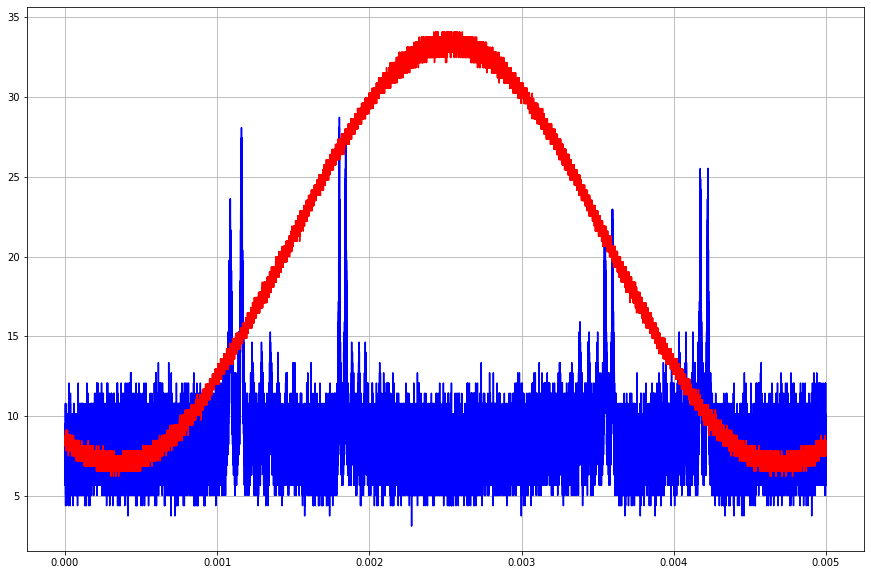

In [70]:
fig = plt.figure(figsize=(15, 10))
ax = fig.add_subplot(1,1,1)
ax.plot(time_dfreq, signal_oor_dfreq*1000, c = 'blue') 
ax.plot(time_dfreq, signal_gen_dfreq+20, c = 'r')
ax.grid()

Отфильруем данные

In [71]:
signal_oor_dfreq = savgol_filter(signal_oor_dfreq, 99, 3)
signal_gen_dfreq = savgol_filter(signal_gen_dfreq, 99, 3)

In [72]:
time_coef = 1e+3
ampl_coef = 1e+3

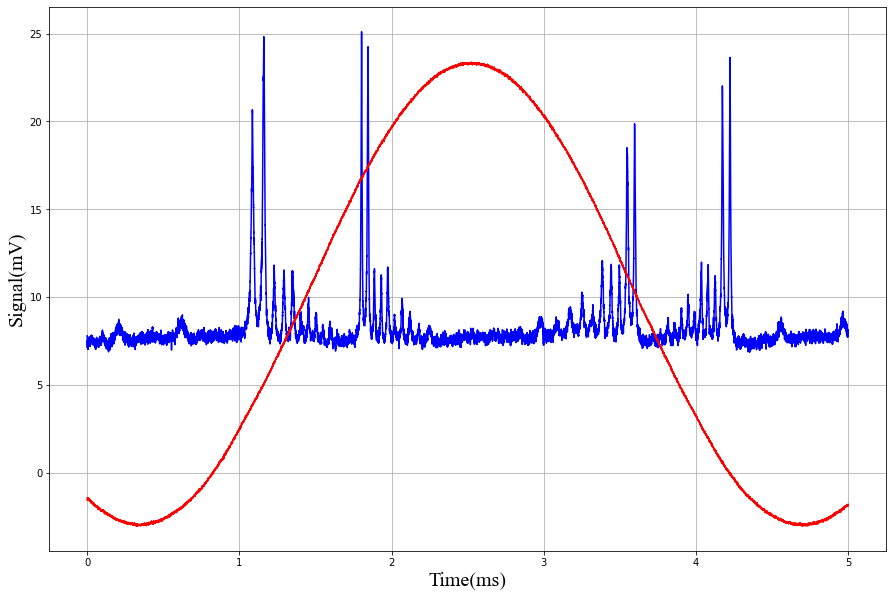

In [73]:
#общий график
fig = plt.figure(figsize=(15, 10))
ax = fig.add_subplot(1,1,1)
ax.plot(time_dfreq * time_coef, signal_oor_dfreq*ampl_coef, c = 'blue') 
ax.plot(time_dfreq * time_coef, signal_gen_dfreq + 10, c = 'r')
ax.grid()
ax.set_xlabel('Time(ms)',{'fontname':'Times New Roman'},fontweight='light',color='k', fontsize=20)
ax.set_ylabel("Signal(mV)",{'fontname':'Times New Roman'},fontweight='light',color='k', fontsize=20)
plt.savefig(save_path + "\\" + "full_graph_of_doble_freq_generation.jpg")

Из оценочного графика видно, какой интервал подходит для определения ООД резонатора лазера лучше всего [44000:47000]


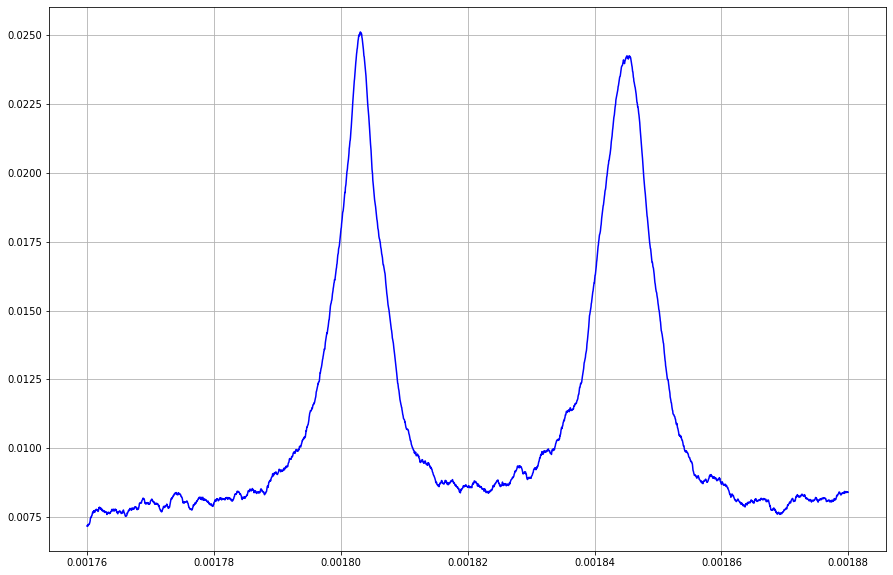

In [74]:
#Ячейка для подгона рабочего  интервала 
fig = plt.figure(figsize=(15, 10))
ax = fig.add_subplot(1,1,1)
ax.plot(time_dfreq[44000:47000], signal_oor_dfreq[44000:47000] , c = 'blue') 
ax.grid()

In [75]:
#переобозначим интересующую на зону
time_dfreq_crop = copy.copy(time_dfreq[44000:47000])
signal_oor_dfreq_filtred_crop = copy.copy(signal_oor_dfreq[44000:47000])
# сдвинем время на 0 и сигнал 
signal_oor_dfreq_filtred_crop = signal_oor_dfreq_filtred_crop - signal_oor_dfreq_filtred_crop.min()
time_dfreq_crop = time_dfreq_crop - time_dfreq_crop[0]

In [76]:
max_time_dfreq_filtred_crop, max_signal_oor_dfreq_filtred_crop, max_ind_dfreq_filtred_crop = find_max([time_dfreq_crop,
                                                                                                       signal_oor_dfreq_filtred_crop
                                                                                                      ], 
                                                                                                      prominence = 0.01,
                                                                                                      distance = 500
                                                                                                         )

вычислим время, отвечающее ОСД

In [77]:
fsr_laser_time = max_time_dfreq_filtred_crop[1] - max_time_dfreq_filtred_crop[0]

Теперь найдём коэффициент пересчета времени в частоту для того, чтобы определить частоту между соседними модами и ОСД сканирующего интерферометра в случае режимов наилучшего и умеренного согласований. 
Тогда выражение для разности частот примет вид: $ \Delta\nu = \Delta t  * \alpha = \frac{\Delta t  * c }{2 L_{laser} * \tau_{dfreq}}$ 

In [78]:
alpha = fsr_laser / fsr_laser_time

Оформим график  для отчета. Далее fsr_laser_time = $\Delta \tau_{fsr}$ на графике

In [79]:
#расчёт точек
time_coef = 1e+6
ampl_coef = 1e+3
line_width = 0.2*1e-3
max_line_width = max_signal_oor_dfreq_filtred_crop.max() * 1.1
arrow_centre = (max_time_dfreq_filtred_crop[1] + max_time_dfreq_filtred_crop[0]) / 2
arrow_high  =  max_signal_oor_dfreq_filtred_crop.max() * 1.05
arrow_length = (max_time_dfreq_filtred_crop[1] - max_time_dfreq_filtred_crop[0]) * 0.9 / 2 
arrow_head_width = line_width
arrow_head_length = (max_time_dfreq_filtred_crop[1] - max_time_dfreq_filtred_crop[0]) * 0.1 / 2 
tau_centre = (arrow_centre - (arrow_length + arrow_head_length)) * 1.35 
tau_high = arrow_high * 1.015


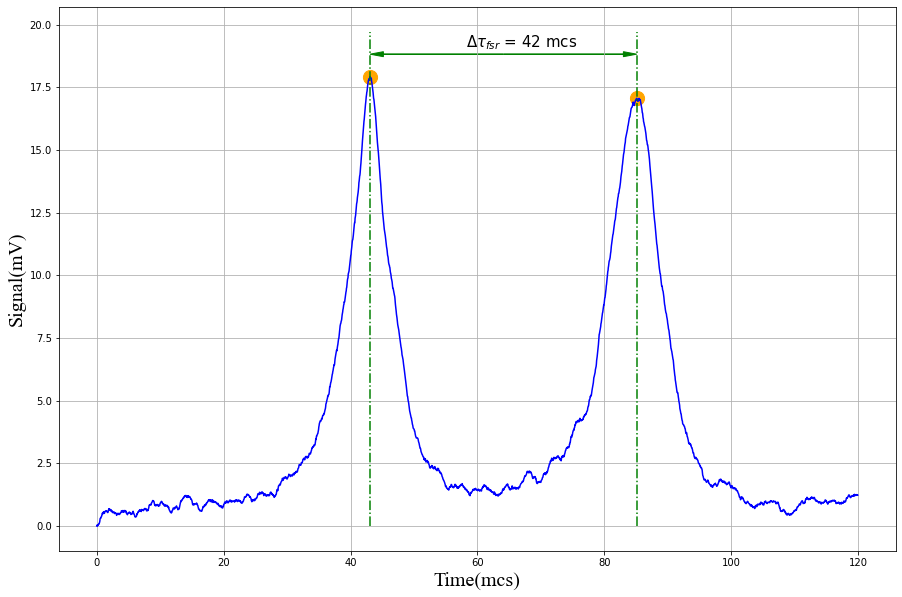

In [80]:
fig = plt.figure(figsize=(15, 10))
ax = fig.add_subplot(1,1,1)
ax.plot(time_dfreq_crop * time_coef , signal_oor_dfreq_filtred_crop * ampl_coef , c = 'blue') 
ax.set_xlabel('Time(mcs)',{'fontname':'Times New Roman'},fontweight='light',color='k', fontsize=20)
ax.set_ylabel("Signal(mV)",{'fontname':'Times New Roman'},fontweight='light',color='k', fontsize=20)
ax.text(tau_centre * time_coef, tau_high * ampl_coef, "$Δτ_{fsr}$ = 42 mcs",fontsize = 15)
ax.scatter(
            time_dfreq_crop[max_ind_dfreq_filtred_crop[0]] * time_coef,
            signal_oor_dfreq_filtred_crop[max_ind_dfreq_filtred_crop[0]] * ampl_coef,
            color="orange", s=200, marker='o' 
            )
ax.scatter(
            time_dfreq_crop[max_ind_dfreq_filtred_crop[1]] * time_coef,
            signal_oor_dfreq_filtred_crop[max_ind_dfreq_filtred_crop[1]] * ampl_coef,
            color="orange", s=200, marker='o' 
            )
ax.vlines(
            time_dfreq_crop[max_ind_dfreq_filtred_crop[0]]* time_coef,
            ymin = 0, ymax = max_line_width * ampl_coef, color = 'green',linestyles = 'dashdot'
            )
ax.vlines(
          time_dfreq_crop[max_ind_dfreq_filtred_crop[1]]* time_coef,
          ymin = 0, ymax = max_line_width * ampl_coef, color = 'green',linestyles = 'dashdot'
            )
ax.arrow(
         arrow_centre * time_coef, arrow_high * ampl_coef, -arrow_length  * time_coef, 0,
         head_width=arrow_head_width * ampl_coef, head_length=arrow_head_length * time_coef, color = 'g'
        )
ax.arrow(
          arrow_centre * time_coef, arrow_high * ampl_coef, arrow_length  * time_coef, 0,
          head_width=arrow_head_width* ampl_coef, head_length=arrow_head_length *time_coef , color = 'g'
        )
ax.grid()
plt.savefig(save_path + "\\" + "peacks_of_doble_freq_generation.jpg")


Когда коэффициент получен, можно определить все, что требуется по заданию 

## Режим наилучшего согласования ООР и сканирующего интерферометра

In [81]:
settings_full_agr, time_full_agr, signal_oor_full_agr, signal_gen_full_agr  = unpack_two_ch(data_path, "full_agreement")
# сдвинем для удобства время на 0
time_full_agr = time_full_agr - time_full_agr[0]

Отфильтруем сигнал

In [82]:
signal_oor_full_agr = savgol_filter(signal_oor_full_agr, 99, 3)
signal_gen_full_agr = savgol_filter(signal_gen_full_agr, 99, 3)

Находим  зону  информативного сигнала на первичном графике
Видно, что зона с индексами [24000:50000] вполне подходит

In [83]:
time_coef = 1e+3
ampl_coef = 1e+3

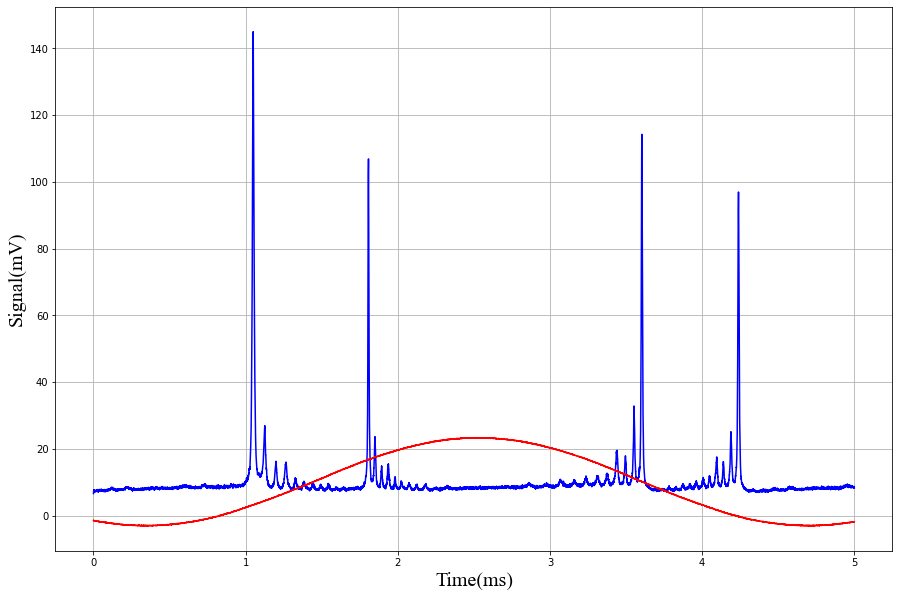

In [84]:
# первичный график
fig = plt.figure(figsize=(15, 10))
ax = fig.add_subplot(1,1,1)
ax.plot(time_full_agr*time_coef, signal_oor_full_agr * ampl_coef, c = 'blue') 
ax.plot(time_full_agr*time_coef, signal_gen_full_agr + 10, c = 'red') 
ax.grid()
ax.set_xlabel('Time(ms)',{'fontname':'Times New Roman'},fontweight='light',color='k', fontsize=20)
ax.set_ylabel("Signal(mV)",{'fontname':'Times New Roman'},fontweight='light',color='k', fontsize=20)
plt.savefig(save_path + "\\" + "full_graph_of_full_agr_generation.jpg")


Наилучший интервал - [24000:50000] 

In [85]:
time_full_agr_crop = copy.copy(time_full_agr[24000:50000])
time_full_agr_crop = time_full_agr_crop - time_full_agr_crop[0]
signal_oor_full_agr_filtred_crop = copy.copy(signal_oor_full_agr[24000:50000]) 
signal_oor_full_agr_filtred_crop = signal_oor_full_agr_filtred_crop - signal_oor_full_agr_filtred_crop.min()

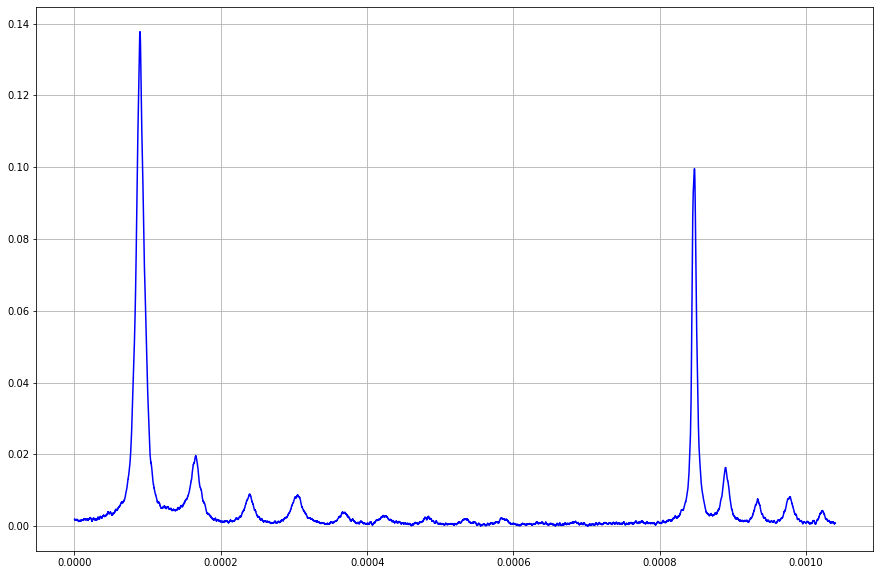

In [86]:
#Ячейка для подгона рабочего  интервала 
fig = plt.figure(figsize=(15, 10))
ax = fig.add_subplot(1,1,1)
ax.plot(time_full_agr_crop, signal_oor_full_agr_filtred_crop, c = 'blue') 
ax.grid()

Найдём максимумы

In [87]:
max_time_full_agr_filtred_crop, max_signal_oor_full_agr_filtred_crop, max_ind_full_agr_filtred_crop = find_max([time_full_agr_crop, signal_oor_full_agr_filtred_crop], 
                                                                                                                  prominence = 0.005,
                                                                                                                  distance = 500
                                                                                                                 )

Найдем ширины пиков

In [88]:
_, half_level_full_agr_crop, left_coord_indx_full_agr_crop, right_coord_indx_full_agr_crop = peak_widths(
                                                                                                            signal_oor_full_agr_filtred_crop, 
                                                                                                            max_ind_full_agr_filtred_crop, 
                                                                                                            rel_height=0.5 
                                                                                                            )

left_coord_indx_full_agr_crop = np.round(left_coord_indx_full_agr_crop).astype('int')
right_coord_indx_full_agr_crop = np.round(right_coord_indx_full_agr_crop).astype('int')


### Вычислим:
а) частотные интервалы между соседними
поперечными модами интерферометра;<br>
б) ширины резонансов для низших и высших
типов колебаний интерферометра

In [89]:
# частотные интервалы между соседними поперечными модами интерферометра
freq_interval_full_agr = np.diff(max_time_full_agr_filtred_crop) * alpha
tau_freq_interval_full_agr = np.diff(max_time_full_agr_filtred_crop)
freq_interval_full_agr = np.delete(freq_interval_full_agr, 3)
tau_freq_interval_full_agr = np.delete(tau_freq_interval_full_agr, 3)
print(freq_interval_full_agr)

[7.34435673e+08 7.10134492e+08 6.34145087e+08 4.07719804e+08
 4.27006455e+08 4.28163654e+08]


In [90]:
# ширины резонансов для низших и высших типов колебаний интерферометра
peak_width_full_agr_crop = calc_width(left_coord_indx_full_agr_crop, right_coord_indx_full_agr_crop, time_full_agr_crop) * alpha
tau_peak_width_full_agr_crop = calc_width(left_coord_indx_full_agr_crop, right_coord_indx_full_agr_crop, time_full_agr_crop)

In [91]:
# Область свободной дисперсии
tau_fsr_full_agr = max_time_full_agr_filtred_crop[4] - max_time_full_agr_filtred_crop[0] 
fsr_full_agr = tau_fsr_full_agr * alpha

### Нарисуем Графики 

In [92]:
time_coef = 1e+6
ampl_coef = 1e+3
line_width = 1e-3
max_line_width = max_signal_oor_full_agr_filtred_crop.max() * 1.1
arrow_centre = (max_time_full_agr_filtred_crop[4] + max_time_full_agr_filtred_crop[0]) / 2
arrow_high  =  max_signal_oor_full_agr_filtred_crop.max() * 1.05
arrow_length = (max_time_full_agr_filtred_crop[4] - max_time_full_agr_filtred_crop[0]) * 0.9 / 2 
arrow_head_width = line_width
arrow_head_length = (max_time_full_agr_filtred_crop[4] - max_time_full_agr_filtred_crop[0]) * 0.1 / 2 
tau_centre = (arrow_centre - (arrow_length + arrow_head_length)) * 4.35 
tau_high = arrow_high * 1.015

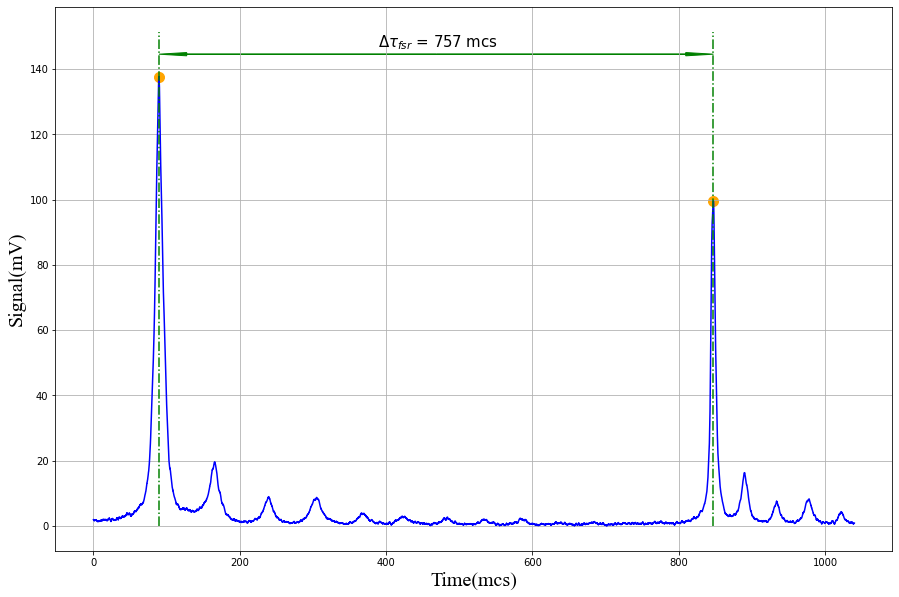

In [93]:
fig = plt.figure(figsize=(15, 10))
ax = fig.add_subplot(1,1,1)
ax.plot(time_full_agr_crop * time_coef, signal_oor_full_agr_filtred_crop * ampl_coef , c = 'blue') 
ax.set_xlabel('Time(mcs)',{'fontname':'Times New Roman'},fontweight='light',color='k', fontsize=20)
ax.set_ylabel("Signal(mV)",{'fontname':'Times New Roman'},fontweight='light',color='k', fontsize=20)
ax.text(tau_centre * time_coef, tau_high * ampl_coef, "$Δτ_{fsr}$ = 757 mcs",fontsize = 15)
ax.scatter(
            time_full_agr_crop[max_ind_full_agr_filtred_crop[0]] * time_coef,
            signal_oor_full_agr_filtred_crop[max_ind_full_agr_filtred_crop[0]] * ampl_coef,
            color="orange", s=100, marker='o' 
            )
ax.scatter(
            time_full_agr_crop[max_ind_full_agr_filtred_crop[4]] * time_coef,
            signal_oor_full_agr_filtred_crop[max_ind_full_agr_filtred_crop[4]] * ampl_coef,
            color="orange", s=100, marker='o' 
            )
ax.vlines(
            time_full_agr_crop[max_ind_full_agr_filtred_crop[0]]* time_coef,
            ymin = 0, ymax = max_line_width * ampl_coef, color = 'green',linestyles = 'dashdot'
            )
ax.vlines(
          time_full_agr_crop[max_ind_full_agr_filtred_crop[4]]* time_coef,
          ymin = 0, ymax = max_line_width * ampl_coef, color = 'green',linestyles = 'dashdot'
            )
ax.arrow(
         arrow_centre * time_coef, arrow_high * ampl_coef, -arrow_length  * time_coef, 0,
         head_width=arrow_head_width * ampl_coef, head_length=arrow_head_length * time_coef, color = 'g'
        )
ax.arrow(
          arrow_centre * time_coef, arrow_high * ampl_coef, arrow_length  * time_coef, 0,
          head_width=arrow_head_width* ampl_coef, head_length=arrow_head_length *time_coef , color = 'g'
        )
ax.grid()
plt.savefig(save_path + "\\" + "full_agr_AFD.jpg")

Нарисуем более детально 

In [94]:
time_coef = 1e+6
l_range = 0
r_range = 10000
ampl_coef = 1e+3
line_width = 1e-3
arrow_head_width = line_width
arrow_params = calc_arrow_params(
                                 left_coord_indx_full_agr_crop[:4], 
                                 right_coord_indx_full_agr_crop[:4],
                                 half_level_full_agr_crop[:4],
                                 300, 
                                 800, 
                                 time_full_agr_crop[l_range:r_range],
                                 0.5
                                )
arrow_params_2 = calc_arrow_params_2(max_ind=max_ind_full_agr_filtred_crop[:4] ,
                                     time=time_full_agr_crop, 
                                     max_level=max_signal_oor_full_agr_filtred_crop[:4], 
                                     arrow_head_procent=0.1, 
                                     tau_step = 0.7
                                     )

vlines_params = calc_vlines_params(max_ind=max_ind_full_agr_filtred_crop[:4] ,
                                   time=time_full_agr_crop,
                                   max_level=max_signal_oor_full_agr_filtred_crop[:4],
                                   start=0)


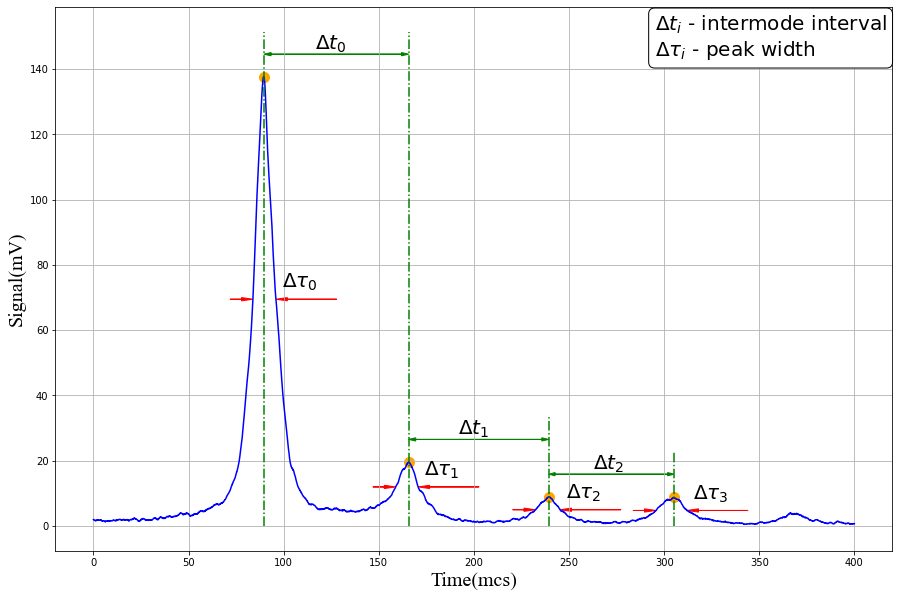

In [95]:
fig = plt.figure(figsize=(15, 10))
ax = fig.add_subplot(1,1,1)
ax.plot(
        time_full_agr_crop[l_range:r_range] * time_coef, 
        signal_oor_full_agr_filtred_crop[l_range:r_range] * ampl_coef , c = 'blue'
        ) 
box = {'facecolor':'white',    
       'edgecolor': 'black',     
       'boxstyle': 'round'}

ax.text(295, 144, ('$Δt_{i}$ - intermode interval\n$Δτ_{i}$ - peak width '),
        bbox = box,
        color = 'black',    
        fontsize = 20)


for i in range(4):
    ax.arrow(
             arrow_params[0][i] * time_coef,  arrow_params[7][i] * ampl_coef, + arrow_params[1][i] * time_coef, 0,
             head_width=arrow_head_width * ampl_coef, head_length=arrow_params[6][i] * time_coef, color = 'r'
            )
    ax.arrow(
             arrow_params[2][i] * time_coef,  arrow_params[7][i] * ampl_coef, -arrow_params[3][i] * time_coef, 0,
             head_width=arrow_head_width * ampl_coef, head_length=arrow_params[6][i] * time_coef, color = 'r'
            )
#     ax.hlines(
#             arrow_params[7][i] * ampl_coef, xmin = arrow_params[4][i] * time_coef, 
#             xmax = arrow_params[5][i] * time_coef, color = 'green'
#             )
    const = str(
                round((time_full_agr_crop[right_coord_indx_full_agr_crop[i]] - 
                time_full_agr_crop[left_coord_indx_full_agr_crop[i]] )* time_coef)
                )
    ax.scatter(
            time_full_agr_crop[max_ind_full_agr_filtred_crop[i]] * time_coef,
            signal_oor_full_agr_filtred_crop[max_ind_full_agr_filtred_crop[i]] * ampl_coef,
            color='orange', s=100, marker='o' 
            )
    
    ax.vlines(vlines_params[i][0] * time_coef, ymin = vlines_params[i][1] * ampl_coef, 
            ymax = vlines_params[i][2] * ampl_coef, color = 'green', linestyles = 'dashdot'
            )
    ax.text(arrow_params[8][i] * time_coef, arrow_params[9][i] * ampl_coef, "$Δτ_{0}$".format(str(i)), fontsize = 20)
for i in range(3):
    ax.arrow(
             arrow_params_2[i][0] * time_coef,  arrow_params_2[i][1] * ampl_coef, + arrow_params_2[i][2] * time_coef, 0,
             head_width=arrow_head_width * ampl_coef, head_length=arrow_params_2[i][3] * time_coef, color = 'g'
            )
    ax.arrow(
             arrow_params_2[i][0] * time_coef,  arrow_params_2[i][1] * ampl_coef, -arrow_params_2[i][2] * time_coef, 0,
             head_width=arrow_head_width * ampl_coef, head_length=arrow_params_2[i][3] * time_coef, color = 'g'
            )
    
    ax.text(arrow_params_2[i][4] * time_coef, arrow_params_2[i][5] * ampl_coef, "$Δt_{0}$".format(str(i)), fontsize = 20)
ax.grid()
ax.set_xlabel('Time(mcs)',{'fontname':'Times New Roman'},fontweight='light',color='k', fontsize=20)
ax.set_ylabel("Signal(mV)",{'fontname':'Times New Roman'},fontweight='light',color='k', fontsize=20)
plt.savefig(save_path + "\\" + "full_agr_widths.jpg")


## Режим умеренного согласования ООР и сканирующего интерферометра

In [96]:
settings_mod_agr, time_mod_agr, signal_oor_mod_agr, signal_gen_mod_agr  = unpack_two_ch(data_path, "moderate_agreement_a")
# сдвинем для удобства время на 0
time_mod_agr = time_mod_agr - time_mod_agr[0]

Отфильтруем сигнал


In [97]:
signal_oor_mod_agr = savgol_filter(signal_oor_mod_agr, 99, 3)
signal_gen_mod_agr = savgol_filter(signal_gen_mod_agr, 99, 3)

In [98]:
time_coef = 1e+3
ampl_coef = 1e+3

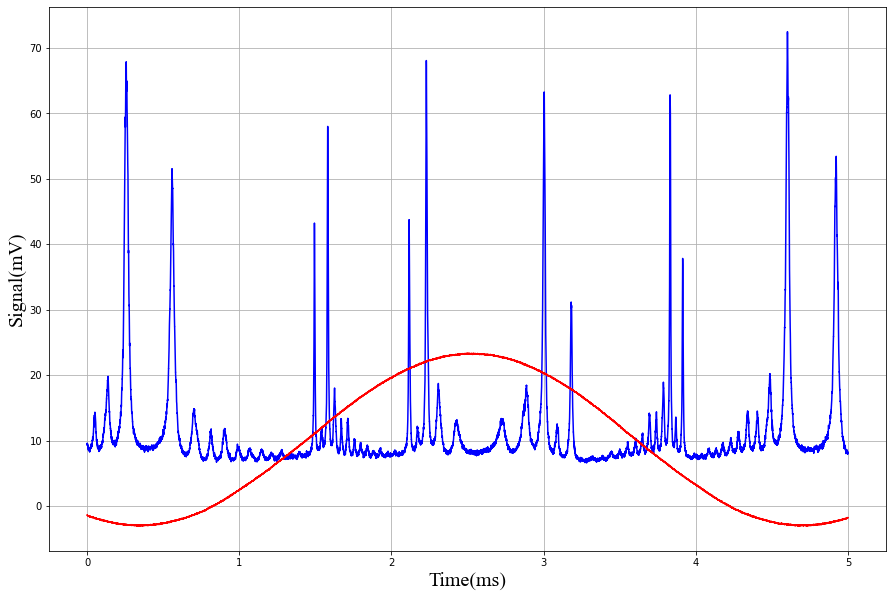

In [99]:
# первичный график всего сигнала
fig = plt.figure(figsize=(15, 10))
ax = fig.add_subplot(1,1,1)

ax.plot(time_mod_agr * time_coef, signal_oor_mod_agr*1000, c = 'blue') 
ax.plot(time_mod_agr * time_coef, signal_gen_mod_agr+10, c = 'r')
ax.grid()
ax.set_xlabel('Time(ms)',{'fontname':'Times New Roman'},fontweight='light',color='k', fontsize=20)
ax.set_ylabel("Signal(mV)",{'fontname':'Times New Roman'},fontweight='light',color='k', fontsize=20)
plt.savefig(save_path + "\\" + "full_graph_of_mod_agr_generation.jpg")

Находим  зону  информативного сигнала на первичном графике
Видно, что зона с индексами [35000:63000] вполне подходит

In [100]:
#Сдвинем для удобства
signal_oor_mod_agr_filtred_crop = copy.copy(signal_oor_mod_agr[35000:63000])
time_mod_agr_crop = copy.copy(time_mod_agr[35000:63000])
time_mod_agr_crop = time_mod_agr_crop - time_mod_agr_crop[0]
signal_oor_mod_agr_filtred_crop = signal_oor_mod_agr_filtred_crop - signal_oor_mod_agr_filtred_crop.min()

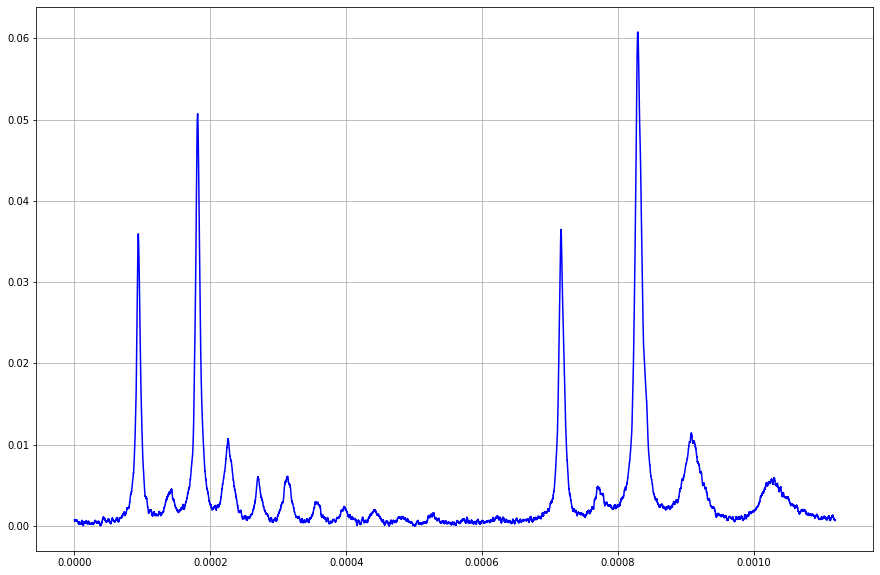

In [101]:
#Ячейка для подгонки интервала
fig = plt.figure(figsize=(15, 10))
ax = fig.add_subplot(1,1,1)
ax.plot(time_mod_agr_crop, signal_oor_mod_agr_filtred_crop, c = 'blue') 
ax.grid()

In [102]:
max_time_mod_agr_filtred_crop, max_signal_oor_mod_agr_filtred_crop, max_ind_mod_agr_filtred_crop = find_max([time_mod_agr_crop, signal_oor_mod_agr_filtred_crop], 
                                                                                                                  prominence = 0.002,
                                                                                                                  distance = 300
                                                                                                                 )

In [103]:
#удалим ненужные пики
max_time_mod_agr_filtred_crop = np.delete(max_time_mod_agr_filtred_crop, [6,7])
max_signal_oor_mod_agr_filtred_crop = np.delete(max_signal_oor_mod_agr_filtred_crop, [6,7])
max_ind_mod_agr_filtred_crop = np.delete(max_ind_mod_agr_filtred_crop, [6,7])

Информация о максимумах 

In [104]:
_, half_level_mod_agr_crop, left_coord_indx_mod_agr_crop, right_coord_indx_mod_agr_crop = peak_widths(
                                                                                                        signal_oor_mod_agr_filtred_crop, 
                                                                                                        max_ind_mod_agr_filtred_crop, 
                                                                                                        rel_height=0.5 
                                                                                                        )

left_coord_indx_mod_agr_crop = np.round(left_coord_indx_mod_agr_crop).astype('int')
right_coord_indx_mod_agr_crop = np.round(right_coord_indx_mod_agr_crop).astype('int')

### Вычислим:
а) частотные интервалы между соседними
поперечными модами интерферометра;<br>
б) ширины резонансов для низших и высших
типов колебаний интерферометра

In [105]:
# частотные интервалы между соседними поперечными модами интерферометра
freq_interval_mod_agr = np.diff(max_time_mod_agr_filtred_crop) * alpha
tau_freq_interval_mod_agr = np.diff(max_time_mod_agr_filtred_crop)
freq_interval_mod_agr = np.delete(freq_interval_mod_agr, 5)
tau_freq_interval_mod_agr = np.delete(tau_freq_interval_mod_agr,5)


In [106]:
# ширины резонансов для низших и высших типов колебаний интерферометра
peak_width_mod_agr_crop = calc_width(left_coord_indx_mod_agr_crop, right_coord_indx_mod_agr_crop, time_mod_agr_crop) * alpha
tau_peak_width_mod_agr_crop = calc_width(left_coord_indx_mod_agr_crop, right_coord_indx_mod_agr_crop, time_mod_agr_crop)

In [107]:
# Область свободной дисперсии
tau_fsr_mod_agr = max_time_mod_agr_filtred_crop[6] - max_time_mod_agr_filtred_crop[0]
fsr_mod_agr = tau_fsr_mod_agr * alpha

### Нарисуем Графики 

In [108]:
time_coef = 1e+6
ampl_coef = 1e+3
line_width = 1e-3
max_line_length = np.sort(max_signal_oor_mod_agr_filtred_crop)[-2] * 1.15
arrow_centre = (max_time_mod_agr_filtred_crop[6] + max_time_mod_agr_filtred_crop[0]) / 2
arrow_high  =  np.sort(max_signal_oor_mod_agr_filtred_crop)[-2] * 1.05
arrow_length = (max_time_mod_agr_filtred_crop[6] - max_time_mod_agr_filtred_crop[0]) * 0.9 / 2 
arrow_head_width = line_width
arrow_head_length = (max_time_mod_agr_filtred_crop[6] - max_time_mod_agr_filtred_crop[0]) * 0.1 / 2 
tau_centre = (arrow_centre - (arrow_length + arrow_head_length)) * 3.5
tau_high = arrow_high * 1.015

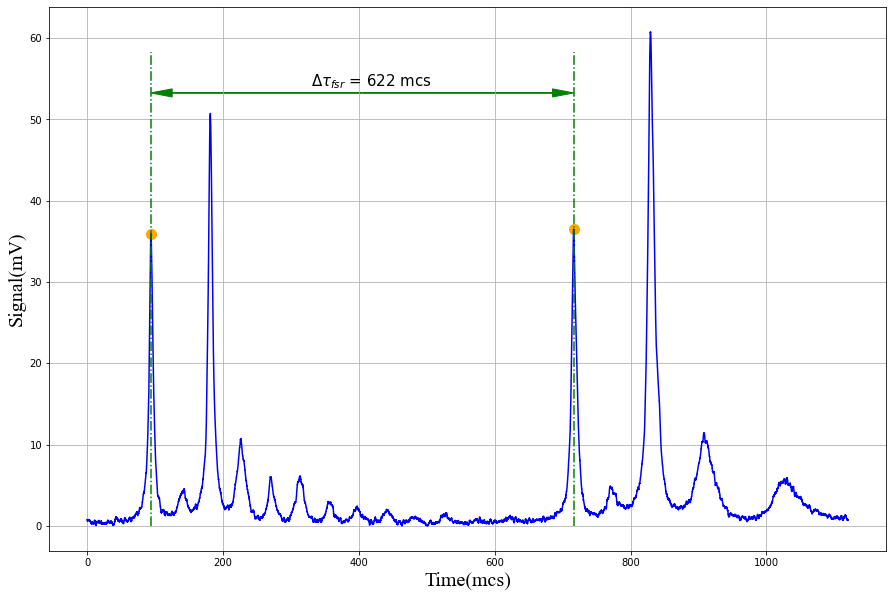

In [109]:
fig = plt.figure(figsize=(15, 10))
ax = fig.add_subplot(1,1,1)
ax.plot(time_mod_agr_crop * time_coef, signal_oor_mod_agr_filtred_crop * ampl_coef , c = 'blue') 
ax.set_xlabel('Time(mcs)',{'fontname':'Times New Roman'},fontweight='light',color='k', fontsize=20)
ax.set_ylabel("Signal(mV)",{'fontname':'Times New Roman'},fontweight='light',color='k', fontsize=20)
ax.text(tau_centre * time_coef, tau_high * ampl_coef, "$Δτ_{fsr}$ = 622 mcs",fontsize = 15)
ax.scatter(
            time_mod_agr_crop[max_ind_mod_agr_filtred_crop[0]] * time_coef,
            signal_oor_mod_agr_filtred_crop[max_ind_mod_agr_filtred_crop[0]] * ampl_coef,
            color='orange', s=100, marker='o' 
            )
ax.scatter(
            time_mod_agr_crop[max_ind_mod_agr_filtred_crop[6]] * time_coef,
            signal_oor_mod_agr_filtred_crop[max_ind_mod_agr_filtred_crop[6]] * ampl_coef,
            color='orange', s=100, marker='o' 
            )
ax.vlines(
            time_mod_agr_crop[max_ind_mod_agr_filtred_crop[0]]* time_coef,
            ymin = 0, ymax = max_line_length * ampl_coef, color = 'green',linestyles = 'dashdot'
            )
ax.vlines(
          time_mod_agr_crop[max_ind_mod_agr_filtred_crop[6]]* time_coef,
          ymin = 0, ymax = max_line_length * ampl_coef, color = 'green',linestyles = 'dashdot'
            )
ax.arrow(
         arrow_centre * time_coef, arrow_high * ampl_coef, -arrow_length  * time_coef, 0,
         head_width=arrow_head_width * ampl_coef, head_length=arrow_head_length * time_coef, color = 'g'
        )
ax.arrow(
          arrow_centre * time_coef, arrow_high * ampl_coef, arrow_length  * time_coef, 0,
          head_width=arrow_head_width* ampl_coef, head_length=arrow_head_length *time_coef , color = 'g'
        )
ax.grid()
plt.savefig(save_path + "\\" + "mod_agr_AFD.jpg")

In [110]:
time_coef = 1e+6
l_range = 0
r_range = 9000
ampl_coef = 1e+3
line_width = 0.5*1e-3
arrow_head_width = line_width
arrow_params = calc_arrow_params(
                                 left_coord_indx_mod_agr_crop[:6], 
                                 right_coord_indx_mod_agr_crop[:6],
                                 half_level_mod_agr_crop[:6],
                                 300, 
                                 800, 
                                 time_mod_agr_crop[l_range:r_range],
                                 0.4
                                )
arrow_params_2 = calc_arrow_params_2(max_ind=max_ind_mod_agr_filtred_crop[:6] ,
                                     time=time_mod_agr_crop, 
                                     max_level=max_signal_oor_mod_agr_filtred_crop[:6], 
                                     arrow_head_procent=0.2, 
                                     tau_step = 0.7
                                     )

vlines_params = calc_vlines_params(max_ind=max_ind_mod_agr_filtred_crop[:6] ,
                                   time=time_mod_agr_crop,
                                   max_level=max_signal_oor_mod_agr_filtred_crop[:6],
                                   start=0)


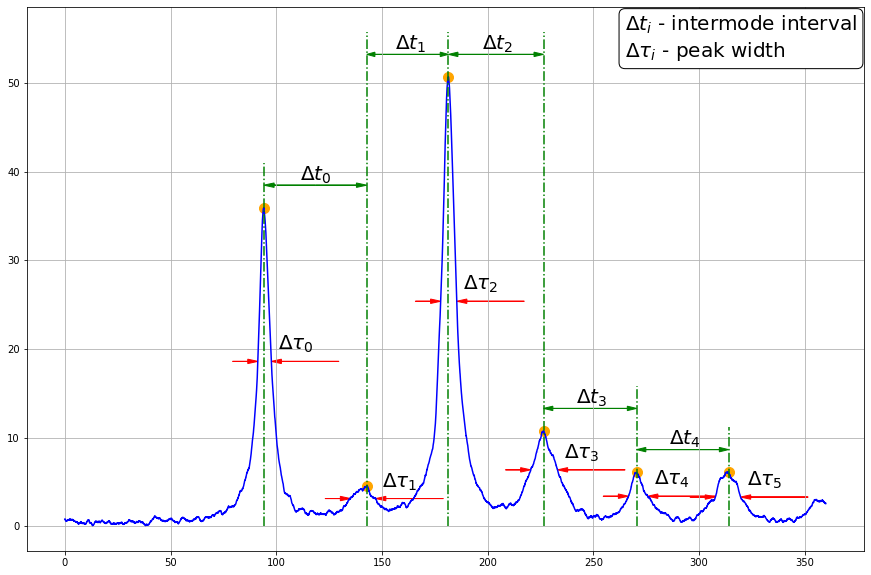

In [111]:
fig = plt.figure(figsize=(15, 10))
ax = fig.add_subplot(1,1,1)
ax.plot(
        time_mod_agr_crop[l_range:r_range] * time_coef, 
        signal_oor_mod_agr_filtred_crop[l_range:r_range] * ampl_coef , c = 'blue'
        ) 

box = {'facecolor':'white',    
       'edgecolor': 'black',     
       'boxstyle': 'round'}

ax.text(265, 53, ('$Δt_{i}$ - intermode interval\n$Δτ_{i}$ - peak width '),
        bbox = box,
        color = 'black',    
        fontsize = 20)

for i in range(6):
    ax.arrow(
             arrow_params[0][i] * time_coef,  arrow_params[7][i] * ampl_coef, + arrow_params[1][i] * time_coef, 0,
             head_width=arrow_head_width * ampl_coef, head_length=arrow_params[6][i] * time_coef, color = 'r'
            )
    ax.arrow(
             arrow_params[2][i] * time_coef,  arrow_params[7][i] * ampl_coef, -arrow_params[3][i] * time_coef, 0,
             head_width=arrow_head_width * ampl_coef, head_length=arrow_params[6][i] * time_coef, color = 'r'
            )
    ax.scatter(
            max_time_mod_agr_filtred_crop[i] * time_coef,  max_signal_oor_mod_agr_filtred_crop[i] * ampl_coef,
            color='orange', s=100, marker='o' 
                )
    ax.text(arrow_params[8][i] * time_coef, arrow_params[9][i] * ampl_coef, "$Δτ_{0}$".format(str(i)), fontsize = 20)
    ax.vlines(vlines_params[i][0] * time_coef, ymin = vlines_params[i][1] * ampl_coef, 
            ymax = vlines_params[i][2] * ampl_coef, color = 'green', linestyles = 'dashdot'
            )
for i in range(5):
    ax.arrow(
             arrow_params_2[i][0] * time_coef,  arrow_params_2[i][1] * ampl_coef, + arrow_params_2[i][2] * time_coef, 0,
             head_width=arrow_head_width * ampl_coef, head_length=arrow_params_2[i][3] * time_coef, color = 'g'
            )
    ax.arrow(
             arrow_params_2[i][0] * time_coef,  arrow_params_2[i][1] * ampl_coef, -arrow_params_2[i][2] * time_coef, 0,
             head_width=arrow_head_width * ampl_coef, head_length=arrow_params_2[i][3] * time_coef, color = 'g'
            )
    
    
    ax.text(arrow_params_2[i][4] * time_coef, arrow_params_2[i][5] * ampl_coef, "$Δt_{0}$".format(str(i)), fontsize = 20)
ax.grid()
plt.savefig(save_path + "\\" + "mod_agr_widths.jpg")

Самое время вывести результаты и посчитать погрешности 

Из осциллограммы двухчастнотного режима было определено время отвечающее определённому частотному интервалу. Относистельная погрешность осциллографа по временной оси составляет $\epsilon_{osc} = $ 0.0005% , что является приборной погрешностью, случайная же в данном случае отсутствует. Поэтому абсолютная погрешность (далее $\Delta$ обозначается абсолютная погрешность, а все $\Delta$ из вычислений и графиков опускаются) $\Delta \tau_{dfreq} = \epsilon_{osc} * \tau_{dfreq}$ .Кроме того Del - абсолютная, del - относительная.    

In [112]:
eps_osc = 5e-4
tau_dfreq = fsr_laser_time
Del_tau_dfreq = eps_osc * tau_dfreq
del_tau_dfreq  = Del_tau_dfreq / tau_dfreq

Знаем, что $\alpha$ = $\frac{fsr_{laser}}{\tau_{dfreq}}$  Тогда  абсолютная погрешность коэффициента $\Delta \alpha$ = $\alpha * \delta \tau_{dfreq} $ = $ \alpha * \epsilon$

In [113]:
Delta_alpha = del_tau_dfreq  * alpha
delta_alpha = eps_osc

Погрешность всех измеренных значений определяется формулой $\Delta \tau_ = \epsilon_{osc} * \tau$, а  погрешность частоты, пересчитанной по этим измерениям вычисляется по формуле $\Delta\nu$  = $\sqrt{(\Delta\tau*\alpha)^2 + (\Delta\alpha*\tau)^2}$ = $(\tau * \alpha)* \sqrt{(\delta\tau)^2 + (\delta \alpha)^2}$ = $\nu * \sqrt{2}*\epsilon_{osc}$      


Но это все приборная погрешность, если у нас есть несклько измеренных величин, которые в теории должны быть одинаковыми,то их  можно считать выборкой случайных величин(например расстояние между поперечными модами).
В качестве погрешности возьмём доверительный интервал для среднего из этих случайных величин те 
$\Delta X_{rand}$ =  $\frac{t_{St}}{N-1}*\sigma $ Где $N$ - количество измерений, $\sigma$ - их дисперсия  $t_{st}$ - коэффициент стьюдента

### Режим наилучшего  согласования

Определим погрешность измеренного времени, отвечающего ОСД 

In [114]:
Delta_tau_fsr_full_agr = eps_osc * tau_fsr_full_agr
delta_tau_fsr_full_agr = eps_osc
print("Область свободной дисперсии в режиме наилучшего согласования в с = ", tau_fsr_full_agr)
print("Абсолютная погрешность = ", round_func([Delta_tau_fsr_full_agr])[0])
print("Относительна погрешность = ", eps_osc)

Область свободной дисперсии в режиме наилучшего согласования в с =  0.0007578400000000001
Абсолютная погрешность =  4e-07
Относительна погрешность =  0.0005


Тогда ОСД  и погрешность ОСД будут равны:

In [115]:

Delta_fsr_full_agr = fsr_full_agr * math.sqrt(2)*eps_osc
delta_fsr_full_agr = math.sqrt(2)*eps_osc
print("Область свободной дисперсии в режиме наилучшего согласования в Гц ", fsr_full_agr)
print("Абсолютная погрешность = ", round_func([Delta_fsr_full_agr])[0])
print("Относительна погрешность = ", round_func([delta_fsr_full_agr])[0])

Область свободной дисперсии в режиме наилучшего согласования в Гц  7308097821.894184
Абсолютная погрешность =  5000000.0
Относительна погрешность =  0.0007


Важная величина, поэтому нужно обработать руками 
$\Delta \nu_{fsr}^{full}= (7.308\pm 0.005)ГГц$  $\epsilon = 0.07\%$

Найдем погрешности ширин пиков.Все они должны быть разными, поэтому ограничимся приборной погрешностью. Кроме того,  возьмём только ширины пиков одной серии.

In [116]:
tau_peak_width_full_agr = tau_peak_width_full_agr_crop[:4]
Delta_tau_peak_width_full_agr = tau_peak_width_full_agr * eps_osc
delta_tau_peak_width_full_agr = eps_osc
print("Ширины пиков Δτ в режиме наилучшего согласования в c,", tau_peak_width_full_agr)
print("Абсолютная погрешность = ", round_func(Delta_tau_peak_width_full_agr))
print("Относительна погрешность = ", round_func([delta_tau_peak_width_full_agr])[0], '\n')

peak_width_full_agr = peak_width_full_agr_crop[:4]
Delta_peak_width_full_agr = peak_width_full_agr * math.sqrt(2)*eps_osc
delta_peak_width_full_agr = math.sqrt(2)*eps_osc

print("Ширины пиков в режиме наилучшего согласования в Гц,", peak_width_full_agr)
print("Абсолютная погрешность = ", round_func(Delta_peak_width_full_agr))
print("Относительна погрешность = ", round_func([delta_peak_width_full_agr])[0])

Ширины пиков Δτ в режиме наилучшего согласования в c, [1.208e-05 1.180e-05 1.296e-05 1.640e-05]
Абсолютная погрешность =  [6e-09, 6e-09, 6e-09, 8e-09]
Относительна погрешность =  0.0005 

Ширины пиков в режиме наилучшего согласования в Гц, [1.16491372e+08 1.13791241e+08 1.24977499e+08 1.58150539e+08]
Абсолютная погрешность =  [80000.0, 80000.0, 90000.0, 100000.0]
Относительна погрешность =  0.0007


В межмодовых частотах отдельно определим приборную погрешность каждой 

In [117]:
tau_freq_interval_full_agr = tau_freq_interval_full_agr[:3]
Delta_tau_freq_interval_full_agr = tau_freq_interval_full_agr * eps_osc
delta_tau_freq_interval_full_agr = eps_osc
print("Межмодовое Δt в режиме наилучшего согласования в c", tau_freq_interval_full_agr)
print("Абсолютная погрешность = ", round_func(Delta_tau_freq_interval_full_agr))
print("Относительна погрешность = ", round_func([delta_tau_freq_interval_full_agr])[0],"\n")

freq_interval_full_agr = freq_interval_full_agr[:3]
Delta_freq_interval_full_agr = freq_interval_full_agr *math.sqrt(2)*eps_osc
delta_freq_interval_full_agr = math.sqrt(2)*eps_osc
freq_interval_full_agr

print("Межмодовое Δt в режиме наилучшего согласования в Гц", freq_interval_full_agr)
print("Абсолютная погрешность = ", round_func(Delta_freq_interval_full_agr))
print("Относительна погрешность = ", round_func([delta_freq_interval_full_agr])[0],"\n")

Межмодовое Δt в режиме наилучшего согласования в c [7.616e-05 7.364e-05 6.576e-05]
Абсолютная погрешность =  [4e-08, 4e-08, 3e-08]
Относительна погрешность =  0.0005 

Межмодовое Δt в режиме наилучшего согласования в Гц [7.34435673e+08 7.10134492e+08 6.34145087e+08]
Абсолютная погрешность =  [500000.0, 500000.0, 400000.0]
Относительна погрешность =  0.0007 



И Приборную и случайную среднего 

In [118]:
Mean_freq_interval_full_agr, Delta_rand_mean_freq_interval_full_agr = rand_error(freq_interval_full_agr, 0.66)
Delta_instr_mean_freq_interval_full_agr = Mean_freq_interval_full_agr * eps_osc
Delta_mean_freq_interval_full_agr = math.sqrt(
                                                Delta_rand_mean_freq_interval_full_agr**2 + 
                                                Delta_instr_mean_freq_interval_full_agr**2
                                             )

delta_mean_freq_interval_full_agr = Delta_mean_freq_interval_full_agr / Mean_freq_interval_full_agr

print("Среднее межмодовое расстояние в режиме наилучшего согласования в Гц", Mean_freq_interval_full_agr )
print("Абсолютная погрешность = ", round_func([Delta_mean_freq_interval_full_agr])[0])
print("Относительна погрешность = ", round_func([delta_mean_freq_interval_full_agr])[0],"\n")

Среднее межмодовое расстояние в режиме наилучшего согласования в Гц 692905083.9612191
Абсолютная погрешность =  30000000.0
Относительна погрешность =  0.04 




$\Delta \nu_{intermod}^{full}= (0.69\pm 0.03)ГГц$  $\epsilon = 4\%$

### Режим умеренного  согласования

Определим погрешность измеренного времени, отвечающего ОСД 

In [119]:
Delta_tau_fsr_mod_agr = eps_osc * tau_fsr_mod_agr
delta_tau_fsr_mod_agr = eps_osc 
tau_fsr_mod_agr
print("Область свободной дисперсии в режиме  умеренного согласования в с = ", tau_fsr_mod_agr)
print("Абсолютная погрешность = ", round_func([Delta_tau_fsr_mod_agr])[0])
print("Относительна погрешность = ", eps_osc)

Область свободной дисперсии в режиме  умеренного согласования в с =  0.0006220800000000001
Абсолютная погрешность =  3e-07
Относительна погрешность =  0.0005


Определим погрешность измеренного времени, отвечающего ОСД 

In [120]:

Delta_fsr_mod_agr = fsr_mod_agr * math.sqrt(2)*eps_osc
delta_fsr_mod_agr = math.sqrt(2)*eps_osc
print("Область свободной дисперсии в режиме наилучшего согласования в Гц ", fsr_mod_agr)
print("Абсолютная погрешность = ", round_func([Delta_fsr_mod_agr])[0])
print("Относительна погрешность = ", round_func([delta_fsr_mod_agr])[0])

Область свободной дисперсии в режиме наилучшего согласования в Гц  5998919947.540292
Абсолютная погрешность =  4000000.0
Относительна погрешность =  0.0007


$\Delta \nu_{fsr}^{mod}= (5.999\pm 0.004)ГГц$  $\epsilon = 0.07\%$

Найдем погрешности ширин пиков.Все они должны быть разными, поэтому ограничимся приборной погрешностью


In [121]:
tau_peak_width_mod_agr = tau_peak_width_mod_agr_crop[:6]
Delta_tau_peak_width_mod_agr = tau_peak_width_mod_agr * eps_osc
delta_tau_peak_width_mod_agr = eps_osc
print("Ширины пиков Δτ в режиме наилучшего согласования в c,", tau_peak_width_mod_agr)
print("Абсолютная погрешность = ", round_func(Delta_tau_peak_width_mod_agr))
print("Относительна погрешность = ", round_func([delta_tau_peak_width_mod_agr])[0], '\n')

peak_width_mod_agr = peak_width_mod_agr_crop[:6]
Delta_peak_width_mod_agr = peak_width_mod_agr * math.sqrt(2)*eps_osc
delta_peak_width_mod_agr = math.sqrt(2)*eps_osc
print("Ширины пиков Δτ в режиме наилучшего согласования в c,", peak_width_mod_agr)
print("Абсолютная погрешность = ", round_func(Delta_peak_width_mod_agr))
print("Относительна погрешность = ", round_func([delta_peak_width_mod_agr])[0], '\n')


Ширины пиков Δτ в режиме наилучшего согласования в c, [6.320e-06 1.192e-05 7.560e-06 1.264e-05 9.080e-06 1.192e-05]
Абсолютная погрешность =  [3e-09, 6e-09, 4e-09, 6e-09, 5e-09, 6e-09]
Относительна погрешность =  0.0005 

Ширины пиков Δτ в режиме наилучшего согласования в c, [6.09458174e+07 1.14948440e+08 7.29035410e+07 1.21891635e+08
 8.75613958e+07 1.14948440e+08]
Абсолютная погрешность =  [40000.0, 80000.0, 50000.0, 90000.0, 60000.0, 80000.0]
Относительна погрешность =  0.0007 



В межмодовых частотах отдельно определим приборную погрешность каждой 

In [122]:
tau_freq_interval_mod_agr = tau_freq_interval_mod_agr[:5] 
Delta_tau_freq_interval_mod_agr = tau_freq_interval_mod_agr * eps_osc
delta_tau_freq_interval_mod_agr = eps_osc
print("Межмодовое Δt в режиме наилучшего согласования в c", tau_freq_interval_mod_agr)
print("Абсолютная погрешность = ", round_func(Delta_tau_freq_interval_mod_agr))
print("Относительна погрешность = ", round_func([delta_tau_freq_interval_mod_agr])[0],"\n")

freq_interval_mod_agr = freq_interval_mod_agr[:5]
Delta_freq_interval_mod_agr = freq_interval_mod_agr *math.sqrt(2)*eps_osc
delta_freq_interval_mod_agr = math.sqrt(2)*eps_osc
print("Межмодовое Δt в режиме наилучшего согласования в Гц", freq_interval_mod_agr)
print("Абсолютная погрешность = ", round_func(Delta_freq_interval_mod_agr))
print("Относительна погрешность = ", round_func([delta_freq_interval_mod_agr])[0],"\n")

Межмодовое Δt в режиме наилучшего согласования в c [4.868e-05 3.864e-05 4.500e-05 4.404e-05 4.348e-05]
Абсолютная погрешность =  [2e-08, 2e-08, 2e-08, 2e-08, 2e-08]
Относительна погрешность =  0.0005 

Межмодовое Δt в режиме наилучшего согласования в Гц [4.69437087e+08 3.72618099e+08 4.33949649e+08 4.24692056e+08
 4.19291794e+08]
Абсолютная погрешность =  [300000.0, 300000.0, 300000.0, 300000.0, 300000.0]
Относительна погрешность =  0.0007 



И Приборную и случайную среднего 

In [123]:
Mean_freq_interval_mod_agr, Delta_rand_mean_freq_interval_mod_agr = rand_error(freq_interval_mod_agr, 0.66)
Delta_instr_mean_freq_interval_mod_agr = Mean_freq_interval_mod_agr * eps_osc
Delta_mean_freq_interval_mod_agr = math.sqrt(
                                                Delta_rand_mean_freq_interval_mod_agr**2 + 
                                                Delta_instr_mean_freq_interval_mod_agr**2
                                             )
delta_mean_freq_interval_mod_agr = Delta_mean_freq_interval_mod_agr /Mean_freq_interval_mod_agr 
print("Среднее межмодовое расстояние в режиме наилучшего согласования в Гц", Mean_freq_interval_mod_agr )
print("Абсолютная погрешность = ", round_func([Delta_mean_freq_interval_mod_agr])[0])
print("Относительна погрешность = ", round_func([delta_mean_freq_interval_mod_agr])[0],"\n")

Среднее межмодовое расстояние в режиме наилучшего согласования в Гц 423997737.0329403
Абсолютная погрешность =  20000000.0
Относительна погрешность =  0.04 



$\Delta \nu_{intermod}^{mod}= (0.42\pm 0.02)ГГц$  $\epsilon = 5\%$

### Задания 

а) Оценить добротность резонатора 


добротность моды $Q = \frac{\nu}{\Delta \nu_{fsr}} =  \frac{с}{\Delta \nu_{fsr} * \lambda_{laser} }$

Добротность мод в случае полного согласования. Так как мы оцениваем добротность для определения коэффициента отражения зеркал, то разумнее это делать для основной моду ввиду больших дифракционных потерь для высших мод

#### Режим наилучшего согласования 

In [124]:

Q_full_agr = c / lamda / fsr_full_agr 
Delta_Q_full_agr = Q_full_agr * delta_peak_width_full_agr
delta_Q_full_agr = delta_peak_width_full_agr
print("Добротность в режиме полного согласования = ",Q_full_agr)
print("Абсолютная погрешность = ", round_func([Delta_Q_full_agr])[0])
print("Относительна погрешность = ", round_func([delta_Q_full_agr])[0],"\n")

Добротность в режиме полного согласования =  64870.976037692264
Абсолютная погрешность =  50.0
Относительна погрешность =  0.0007 



$Q^{full} = 64870 \pm 50 ~~~\epsilon = 0.7\%$

#### Режим умеренного согласования

In [125]:
Q_mod_agr = c / lamda / fsr_mod_agr 
Delta_Q_mod_agr = Q_mod_agr * delta_peak_width_mod_agr
delta_Q_mod_agr = delta_peak_width_mod_agr
print("Добротность в режиме умеренного согласования = ",Q_mod_agr)
print("Абсолютная погрешность = ", round_func([Delta_Q_mod_agr])[0])
print("Относительна погрешность = ", round_func([delta_Q_mod_agr])[0],"\n")

Добротность в режиме умеренного согласования =  79028.13220229665
Абсолютная погрешность =  60.0
Относительна погрешность =  0.0007 



$Q^{mod} = 79030 \pm 60 ~~~\epsilon = 0.7\%$

б) Оценить коэффициенты отражения зеркал


Оценим из предположения малости дифракционных потерь(только для основной моды) и равенства коэффициента пропускания зеркал. $\Delta \nu_{res} = \frac{c*(1-\rho)}{2\pi*L*\sqrt{\rho}}$ где $\rho = \sqrt{\rho_{1}*\rho_{2}}$. Если зеркала глухие, то $\sqrt{\rho_{1}*\rho_{2}}\approx 1$, следовательно, при $\rho_{1} = \rho_{2}$  $\Rightarrow$   $\rho =  1 - \frac{\Delta \nu_{res} * 2\pi*L}{c} = 1 - \pi*\frac{\Delta\nu_{res}}{\Delta \nu_{fsr}} $ <br> Абсолютная погрешность коэффициента отражения будет равна $\Delta\rho = \rho*\sqrt{(\delta\Delta\nu_{res})^{2}+(\delta\Delta\nu_{fsr})^{2}}$

#### Режим наилучшего согласования 


In [126]:
rho_full_agr = 1 - np.pi* peak_width_full_agr[0]  / fsr_full_agr
Delta_rho_full_agr = rho_full_agr*math.sqrt(delta_peak_width_full_agr**2 + delta_fsr_full_agr**2)
delta_rho_full_agr =  Delta_rho_full_agr / rho_full_agr
print("Коэффициент отражения зеркал ", rho_full_agr)
print("Абсолютная погрешность = ", round_func([Delta_rho_full_agr])[0])
print("Относительна погрешность = ", round_func([delta_rho_full_agr])[0],"\n")

Коэффициент отражения зеркал  0.9499228870799059
Абсолютная погрешность =  0.0009
Относительна погрешность =  0.001 



$\rho^{full} = 0.9499 \pm  0.0009~~\epsilon=0.1\%  $ 

 #### Режим умеренного согласования 

In [127]:
rho_mod_agr = 1 - np.pi* peak_width_mod_agr[0]  / fsr_mod_agr
Delta_rho_mod_agr = rho_mod_agr*math.sqrt(delta_peak_width_mod_agr**2 + delta_fsr_mod_agr**2)
delta_rho_mod_agr =  Delta_rho_mod_agr / rho_mod_agr
print("Коэффициент отражения зеркал ", rho_mod_agr)
print("Абсолютная погрешность = ", round_func([Delta_rho_mod_agr])[0])
print("Относительна погрешность = ", round_func([delta_rho_mod_agr])[0],"\n")

Коэффициент отражения зеркал  0.9680830993269557
Абсолютная погрешность =  0.00097
Относительна погрешность =  0.001 



$\rho^{full} = 0.9680 \pm  0.0009~~\epsilon=0.1\%  $

В) Оценить параметры $g$.<br>
Формула, задающая межмодовое расстояние равна $\Delta\nu_{intermod} = \frac{c}{\pi2L}*\arccos{(\sqrt{g_{1}g_{2}})} = \frac{\Delta\nu_{fsr}}{\pi}*\arccos{(\sqrt{g_{1}g_{2}})}$<br>
В силу одинаковых зеркал $g_{1} = g_{2}$ отсюда следует $g = \cos(\frac{\pi\Delta\nu_{intermode}}{\Delta\nu_{fsr}})$<br>
Абсолютная погрешност  $\Delta g = \frac{\pi\Delta\nu_{intermode}}{\Delta\nu_{fsr}}\sin{(\frac{\pi\Delta\nu_{intermode}}{\Delta\nu_{fsr}})}\sqrt{(\delta\Delta\nu_{fsr})^2 + (\delta\Delta\nu_{intermode})^2}$

#### Режим наилучшего согласования 

In [128]:
g_full_agr = math.cos(math.pi*Mean_freq_interval_full_agr / fsr_full_agr ) 
Delta_g_full_agr = (
                    math.pi* Mean_freq_interval_full_agr / fsr_full_agr * 
                    math.sin(math.pi* Mean_freq_interval_full_agr / fsr_full_agr)*
                    math.sqrt((delta_mean_freq_interval_full_agr)**2 + (delta_fsr_full_agr)**2)
                    )
delta_g_full_agr = Delta_g_full_agr / g_full_agr
print("g параметр = ", g_full_agr)
print("Абсолютная погрешность = ", round_func([Delta_g_full_agr])[0])
print("Относительна погрешность = ", round_func([delta_g_full_agr])[0],"\n")   

g параметр =  0.9559652885853455
Абсолютная погрешность =  0.004
Относительна погрешность =  0.004 



$g^{full} = 0.956 \pm 0.004 ~~ \epsilon = 0.4\% $

#### Режим умеренного согласования 

In [129]:
g_mod_agr = math.cos(math.pi*Mean_freq_interval_mod_agr / fsr_mod_agr ) 
Delta_g_mod_agr = (
                    math.pi* Mean_freq_interval_mod_agr / fsr_mod_agr * 
                    math.sin(math.pi* Mean_freq_interval_mod_agr / fsr_mod_agr)*
                    math.sqrt((delta_mean_freq_interval_mod_agr)**2 + (delta_fsr_mod_agr)**2)
                    )
delta_g_mod_agr = Delta_g_mod_agr / g_mod_agr
print("g параметр = ", g_mod_agr)
print("Абсолютная погрешность = ", round_func([Delta_g_mod_agr])[0])
print("Относительна погрешность = ", round_func([delta_g_mod_agr])[0],"\n") 

g параметр =  0.9754492030158786
Абсолютная погрешность =  0.002
Относительна погрешность =  0.002 



$g^{mod} = 0.975 \pm 0.002 ~~ \epsilon = 0.2\% $

#### Истинное значение

$g^{real} = 1 - \frac{L_{interf}}{R_{interf}} = 0.95$

In [130]:
g_real = 1 - L_interf/R_interf

In [131]:
g_real

0.95